1. Implement in python the detoning method described in Section 2.6

denoised matrix 우선 생성

In [2]:
import numpy as np
import pandas as pd

def get_eigen_values_and_vectors(corr:pd.DataFrame):
    e_val, e_vec = np.linalg.eig(corr)
    indices = np.argsort(e_val)[::-1]
    e_val = e_val[indices]
    e_vec = e_vec[:, indices]
    e_val=np.diagflat(e_val)
    return e_val, e_vec

def get_random_cov_matrix(n_cols:int, n_rank:int) -> np.ndarray:
    '''Generate a random covariance matrix with a specified rank.
    '''
    w=np.random.normal(size=(n_cols, n_rank))
    cov_matrix = np.dot(w, w.T)
    cov_matrix+=np.diag(np.random.uniform(size=n_cols))
    return cov_matrix

def get_corr_matrix(cov_matrix:np.ndarray) -> np.ndarray:
    '''
    Convert a covariance matrix to a correlation matrix.
    '''
    std_dev = np.sqrt(np.diag(cov_matrix))
    corr_matrix = cov_matrix / np.outer(std_dev, std_dev)
    corr_matrix[corr_matrix > 1] = 1
    corr_matrix[corr_matrix < -1] = -1
    return corr_matrix

alpha, n_cols, n_rank, q=0.995, 1000, 100, 10
cov=np.cov(np.random.normal(size=(n_cols*q, n_cols)), rowvar=False)
cov=alpha * cov + (1-alpha) * get_random_cov_matrix(n_cols, n_rank) # signal + noise
corr_matrix = get_corr_matrix(cov)
e_val, e_vec = get_eigen_values_and_vectors(corr_matrix)

def get_denoised_corr_matrix(e_val:np.ndarray, e_vec:np.ndarray, n_ranks:int) -> np.ndarray:
    e_val_denoised = np.diag(e_val).copy()
    e_val_denoised[n_ranks:] = e_val_denoised[n_ranks:].sum()/(e_val_denoised.shape[0] - n_ranks) # e_val max를 넘지못하는 eigen_value들은 모두 noise로 간주
    e_val_denoised = np.diag(e_val_denoised)
    cov_matrix=e_vec @ e_val_denoised @ e_vec.T
    corr_matrix = get_corr_matrix(cov_matrix)
    return corr_matrix

corr_matrix_denoised = get_denoised_corr_matrix(e_val, e_vec, n_rank)
e_val_denoised, e_vec_denoised = get_eigen_values_and_vectors(corr_matrix_denoised)

In [3]:


def get_denoting_corr_matrix(denoised_corr_matrix:np.ndarray)->np.ndarray:
    """
    Denoise the correlation matrix using the Marcenko-Pastur distribution.
    """
    e_val, e_vec = get_eigen_values_and_vectors(denoised_corr_matrix)

    market_e_val, market_e_vec = np.array([e_val[0, 0]]).reshape(-1, 1), e_vec[:, 0].reshape(-1, 1)
    denoted_corr_matrix=denoised_corr_matrix - market_e_vec @ market_e_val @ market_e_vec.T
    denoted_corr_matrix=get_corr_matrix(denoted_corr_matrix)
    return denoted_corr_matrix

corr_matrix_denoted = get_denoting_corr_matrix(corr_matrix_denoised)
e_val_denoted, e_vec_denoted = get_eigen_values_and_vectors(corr_matrix_denoted)

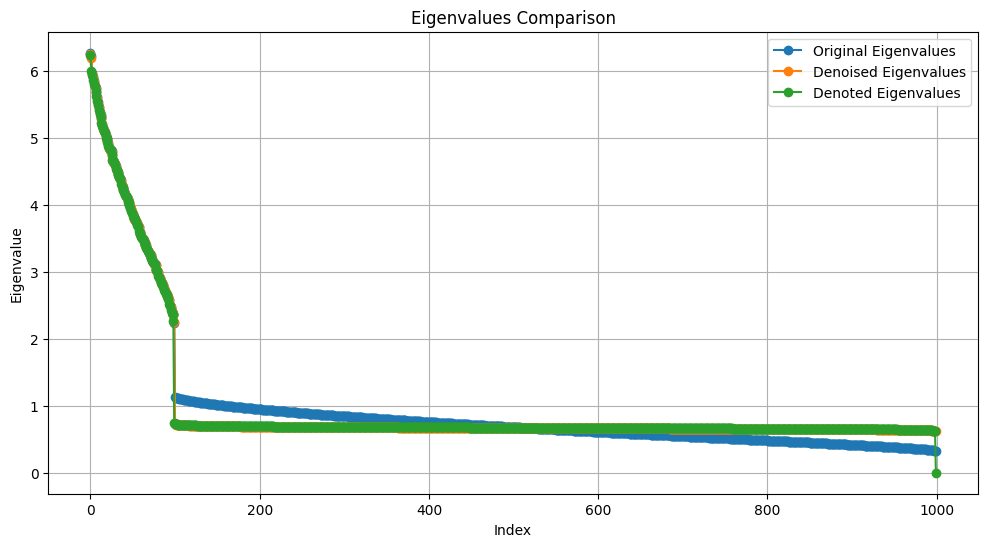

In [4]:
import matplotlib.pyplot as plt

e_val_sorted = np.sort(np.diag(e_val))[::-1]
e_val_denoised_sorted = np.sort(np.diag(e_val_denoised))[::-1]
e_val_denoted_sorted = np.sort(np.diag(e_val_denoted))[::-1]

plt.figure(figsize=(12, 6))
plt.plot(e_val_sorted, label='Original Eigenvalues', marker='o')
plt.plot(e_val_denoised_sorted, label='Denoised Eigenvalues', marker='o')
plt.plot(e_val_denoted_sorted, label='Denoted Eigenvalues', marker='o')
plt.title('Eigenvalues Comparison')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.legend()
plt.grid()
plt.show()

2. Using a series of matrix of stock returns:

In [5]:
etf_price= pd.read_csv('industry_etf_price.csv', index_col=0, parse_dates=True)
etf_returns = etf_price.pct_change().dropna()


2-a. Compute the covariance matrix. What is the condition number of the
correlation matrix?

In [6]:
cov=np.cov(etf_returns, rowvar=False)
condition_number = np.linalg.cond(cov)
print(f"Condition number of the covariance matrix: {condition_number}")

Condition number of the covariance matrix: 1895171.666456906


2-b Compute one hundred efficient frontiers by drawing one hundred alter
native vectors of expected returns from a Normal distribution with mean
10% and standard deviation 10%.

/opt/homebrew/anaconda3/envs/AFML/lib/python3.12/site-packages/cvxpy/problems/problem.py:1510: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Error for target return -0.11284981425642529: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.
Error for target return 0.3161001386906867: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.
Error for target return 0.29005856177366196: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.
Error for target return -0.0830555637356436: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.
Error for target return 0.30257767019453247: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.
Error for target return -0.13240284028218638: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.
Error for target return -0.12289133280775678: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.
Error for target return 0.3742030573274585: So

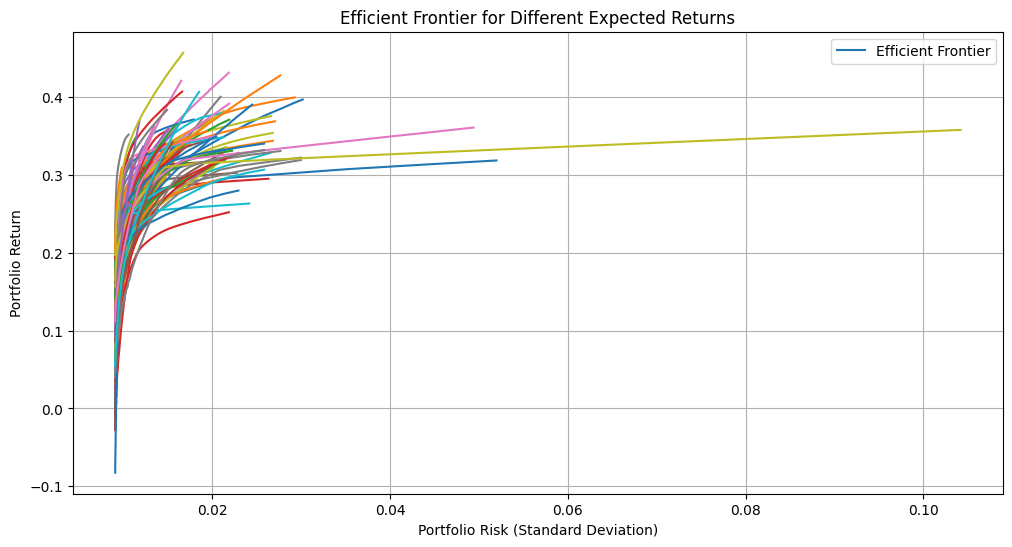

In [23]:
sample_size=100
expected_returns=np.random.normal(0.1, 0.1, size=(sample_size, etf_returns.shape[1]))
import cvxpy as cp
from sklearn.covariance import LedoitWolf

def construct_efficient_frontier(mu:np.ndarray, cov:np.ndarray):
    """
    Construct the efficient frontier given expected returns and covariance matrix.
    """
    n_assets = mu.shape[0]
    frontier_points = []
    cov_matrix_psd = cp.psd_wrap(cov)
    for target_return in np.linspace(mu.min(), mu.max(), 100):
        try:
            weights = cp.Variable(n_assets)
            portfolio_return = mu.T @ weights
            portfolio_variance = cp.quad_form(weights, cov_matrix_psd)

            weight_epsilon = 1e-8
            return_epsilon = 1e-8

            constraints = [
                cp.sum(weights) <= 1 + weight_epsilon,  # Weights sum to 1
                cp.sum(weights) >= 1 - weight_epsilon,  # Weights sum to
                portfolio_return >= target_return - return_epsilon,  # Portfolio return meets target
                portfolio_return <= target_return + return_epsilon,  # Portfolio return does not exceed target
                weights >= 0  # No short selling
            ]

            problem = cp.Problem(cp.Minimize(portfolio_variance), constraints)
            problem.solve()

            if problem.status == cp.OPTIMAL:
                frontier_points.append((target_return, np.sqrt(portfolio_variance.value)))
        except Exception as e:
            print(f"Error for target return {target_return}: {e}")
            continue

    min_variance_return = min(frontier_points, key=lambda x: x[1])[0]
    valid_idx=np.array([x[0] >= min_variance_return for x in frontier_points])
    frontier_points = [x for i, x in enumerate(frontier_points) if valid_idx[i]]
    return np.array(frontier_points)


def plt_efficient_frontier(expected_returns:np.ndarray, cov:np.ndarray):
    frontier_results = []
    for i, mu in enumerate(expected_returns):
        mu = mu.reshape(-1, 1)
        frontier = construct_efficient_frontier(mu, cov)
        frontier_results.append(frontier)
        if i== 0:
            plt.figure(figsize=(12, 6))
            plt.plot(frontier[:, 1], frontier[:, 0], label='Efficient Frontier')
        else:
            plt.plot(frontier[:, 1], frontier[:, 0])
    plt.title('Efficient Frontier for Different Expected Returns')
    plt.xlabel('Portfolio Risk (Standard Deviation)')
    plt.ylabel('Portfolio Return')
    plt.legend()
    plt.grid()
    plt.show()
    return frontier_results

frontier_results=plt_efficient_frontier(expected_returns, cov)


2-c Compute the variance of the errors against the mean efficient frontier.

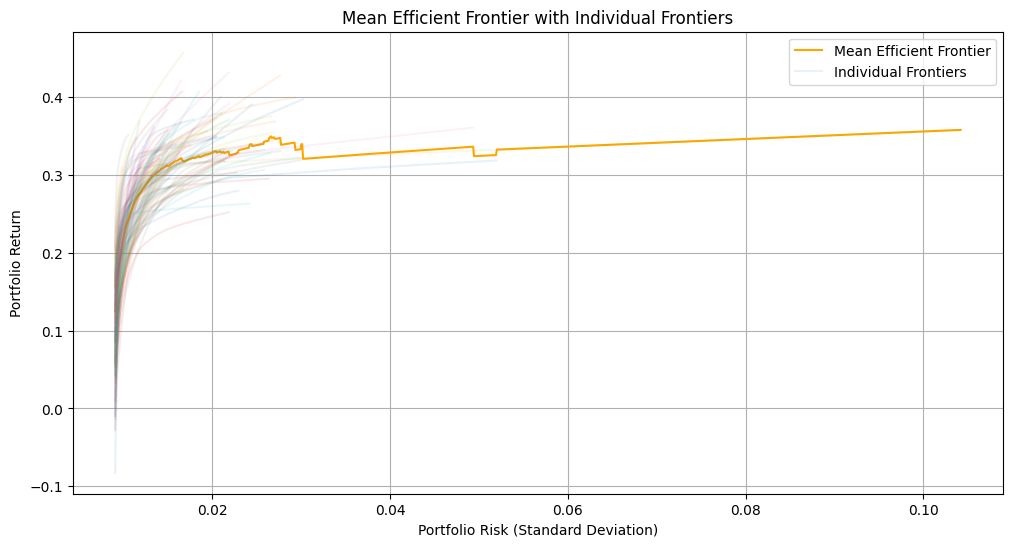

In [25]:

from scipy.interpolate import interp1d
def plt_mean_efficient_frontier(frontier_results:list):
    global_min_risk= min(frontier[:, 1].min() for frontier in frontier_results)
    global_max_risk = max(frontier[:, 1].max() for frontier in frontier_results)
    global_grid= np.linspace(global_min_risk, global_max_risk, 1000)

    # 각 frontier 결과를 common grid에 맞춰 보간
    inter_polated_frontier_results = []
    for frontier in frontier_results:
        f = interp1d(frontier[:, 1], frontier[:, 0], bounds_error=False, fill_value=np.nan)
        inter_polated_frontier = f(global_grid)
        inter_polated_frontier_results.append(inter_polated_frontier)

    inter_polated_frontier_results= np.array(inter_polated_frontier_results)
    mean_frontier = np.nanmean(inter_polated_frontier_results, axis=0)

    plt.figure(figsize=(12, 6))
    plt.plot(global_grid, mean_frontier, label='Mean Efficient Frontier', color='orange')
    for i, frontier in enumerate(frontier_results):
        if i==0:
            plt.plot(frontier[:, 1], frontier[:, 0], label='Individual Frontiers', alpha=0.1)
        else: 
            plt.plot(frontier[:, 1], frontier[:, 0], alpha=0.1)
    plt.title('Mean Efficient Frontier with Individual Frontiers')
    plt.xlabel('Portfolio Risk (Standard Deviation)')
    plt.ylabel('Portfolio Return')
    plt.legend()
    plt.grid()
    plt.show()
    return mean_frontier, inter_polated_frontier_results

mean_frontier, inter_polated_frontier_results = plt_mean_efficient_frontier(frontier_results)


In [26]:
errors=inter_polated_frontier_results - mean_frontier
var_errors = np.nanvar(errors)
print(f"Variance of errors: {var_errors}")


Variance of errors: 0.0011345051396626604


3. Repeat Exercise 2, where this time you denoise the covariance matrix before
computing the one hundred efficient frontiers

Optimization successful: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL, var=1.0000
Estimated maximum eigenvalue: 3.7120, Number of ranks: 3


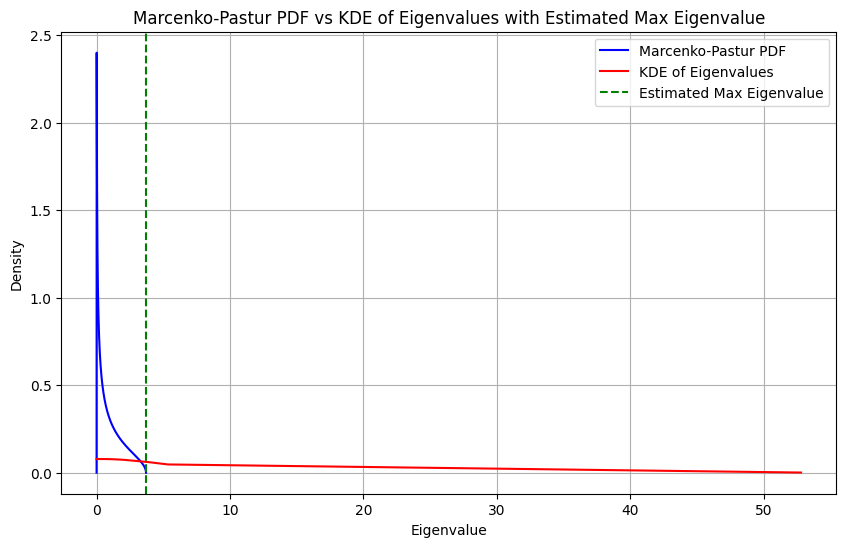

In [49]:
corr=get_corr_matrix(cov)
e_val, e_vec = get_eigen_values_and_vectors(corr)

import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity
from scipy.optimize import minimize
from typing import Tuple

def get_marcenko_pastur_pdf(var:float, q:float, sample_size:int) -> pd.Series:
    '''
    Calculate the Marcenko-Pastur probability density function (PDF) for a given variance,
    ratio of T/N (q), and sample size.
    '''
    min_eigen_value=var*(1-(1/q)**0.5)**2
    max_eigen_value=var*(1+(1/q)**0.5)**2
    eigen_value_range = np.linspace(min_eigen_value, max_eigen_value, sample_size)
    pdf=q/(2*np.pi*var*eigen_value_range)* np.sqrt((max_eigen_value-eigen_value_range)*(eigen_value_range-min_eigen_value))
    pdf=pd.Series(pdf, index=eigen_value_range)
    return pdf  

def get_kde(obs:np.ndarray, b_width:float=0.25, kernel:str='gaussian', x=None) -> pd.Series:
    if len(obs.shape)==1: 
        obs = obs.reshape(-1, 1)
    kde = KernelDensity(kernel=kernel, bandwidth=b_width).fit(obs)
    if x is None:
        x=np.unique(obs).reshape(-1, 1)
    if len(x.shape)==1:
        x = x.reshape(-1, 1)
    log_p=kde.score_samples(x)
    pdf=pd.Series(np.exp(log_p), index=x.flatten())
    return pdf

def get_max_eval(e_val:np.ndarray, q:float, b_width:float, verbose=True)-> Tuple[float, float]:
    '''
    Find the maximum eigenvalue and its corresponding bandwidth.
    '''
    def objective(var:np.ndarray, e_val, q, b_width, sample_size=1000):
        mp_pdf= get_marcenko_pastur_pdf(var[0], q, sample_size)
        kde_pdf = get_kde(e_val, b_width=b_width, x=mp_pdf.index.values)
        sse= np.sum((mp_pdf - kde_pdf) ** 2)
        return sse
    
    out=minimize(lambda *x: objective(*x), 0.5, args=(e_val, q, b_width), bounds=[(1e-5, 1-1e-5),])
    var=out.x[0] if out.success else 1
    if out.success and verbose:
        print(f"Optimization successful: {out.message}, var={var:.4f}")
    e_max= var * (1 + (1/q)**0.5)**2
    return e_max, var
b_width=4.977024
e_max, var = get_max_eval(np.diag(e_val), q=etf_returns.shape[0]/etf_returns.shape[1], b_width=b_width)
eig_values = np.diag(e_val)
eig_values_sorted = np.sort(eig_values)[::-1]  # 내림차순
n_ranks = np.sum(eig_values_sorted > e_max)

pdf1= get_marcenko_pastur_pdf(var=var, q=etf_returns.shape[0]/etf_returns.shape[1], sample_size=1000)
pdf2 = get_kde(np.diag(e_val), b_width=b_width)
plt.figure(figsize=(10, 6))
plt.plot(pdf1.index, pdf1, label='Marcenko-Pastur PDF', color='blue')
plt.plot(pdf2.index, pdf2, label='KDE of Eigenvalues', color='red')
plt.axvline(e_max, color='green', linestyle='--', label='Estimated Max Eigenvalue')
plt.title('Marcenko-Pastur PDF vs KDE of Eigenvalues with Estimated Max Eigenvalue')
plt.xlabel('Eigenvalue')
plt.ylabel('Density')
plt.legend()
plt.grid()  

print(f"Estimated maximum eigenvalue: {e_max:.4f}, Number of ranks: {n_ranks}")

Optimization successful: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL, var=1.0000


/opt/homebrew/anaconda3/envs/AFML/lib/python3.12/site-packages/cvxpy/problems/problem.py:1510: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Error for target return -0.11284981425642529: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.
Error for target return 0.3161001386906867: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.
Error for target return 0.29005856177366196: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.
Error for target return 0.30257767019453247: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.
Error for target return -0.1035482706663301: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.
Error for target return -0.13240284028218638: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.
Error for target return 0.3742030573274585: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.


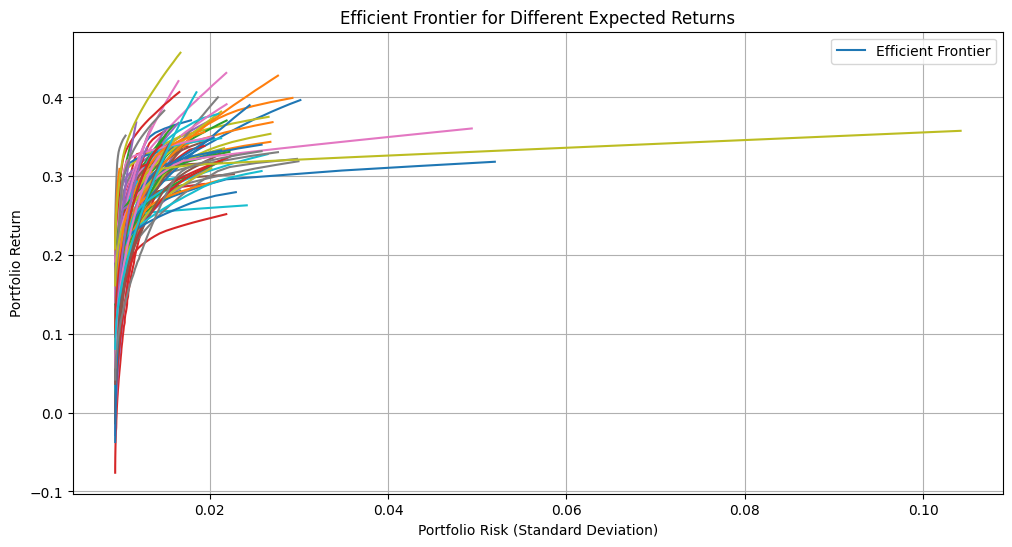

In [50]:
def get_denoised_cov_matrix(cov_matrix:np.ndarray, q:int, b_width:float, verbose=True)->np.ndarray:
    corr_matrix = get_corr_matrix(cov_matrix)
    e_val, e_vec = get_eigen_values_and_vectors(corr_matrix)
    e_max, var = get_max_eval(np.diag(e_val), q=q, b_width=b_width, verbose=verbose)
    n_ranks = np.sum(np.diag(e_val) > e_max)
    corr_matrix_denoised = get_denoised_corr_matrix(e_val, e_vec, n_ranks)
    cov_matrix_denoised=corr_matrix_denoised * np.outer(np.sqrt(np.diag(cov_matrix)), np.sqrt(np.diag(cov_matrix)))
    return cov_matrix_denoised

denoised_cov_matrix = get_denoised_cov_matrix(cov, q=etf_returns.shape[0]/etf_returns.shape[1], b_width=b_width)
frontier_results = plt_efficient_frontier(expected_returns, denoised_cov_matrix)


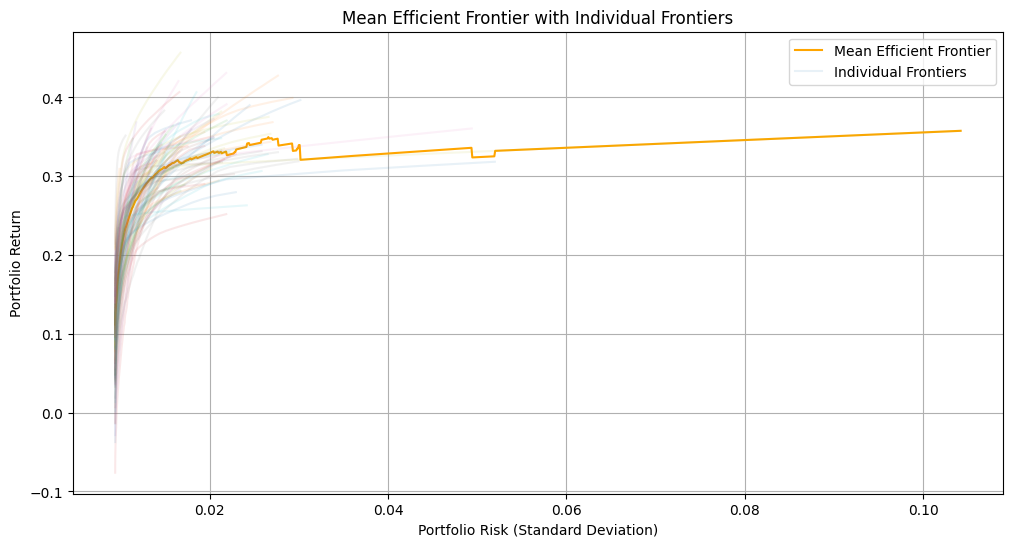

In [51]:
inter_polated_frontier_results, mean_frontier = plt_mean_efficient_frontier(frontier_results)

In [52]:
errors=inter_polated_frontier_results - mean_frontier
var_errors = np.nanvar(errors)
print(f"Variance of errors: {var_errors}")

Variance of errors: 0.001187765940762281


3-a. What is the value of $\sigma^2$ implied by the Marcenko–Pastur distribution?

최적의 fitting을 한 결과 1.0 정도이다.

3-b How many eigenvalues are associated with random components?

In [53]:
print('random_component:', etf_price.shape[1]-n_ranks)

random_component: 76


3-c Is the variance of the errors significantly higher or lower? Why?

생각보다 큰 차이가 발생하지는 않았다.  두 모델 모두에서 solver가 일부 실패했으며, random component가 rank에 비해 압도적으로 많은 상황이므로 공분산 행렬 자체가 여전히 불안정한 상태로 판단된다.

4 Repeat Exercise 2, where this time you apply the Ledoit–Wolf shrinkage
method (instead of denoising) on the covariance matrix before computing the
one hundred efficient frontiers. Is the variance of the errors significantly
higher or lower? Why?

/opt/homebrew/anaconda3/envs/AFML/lib/python3.12/site-packages/cvxpy/problems/problem.py:1510: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Error for target return -0.11284981425642529: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.
Error for target return 0.30257767019453247: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.
Error for target return -0.13240284028218638: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.
Error for target return -0.1276470865449716: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.
Error for target return 0.3742030573274585: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.


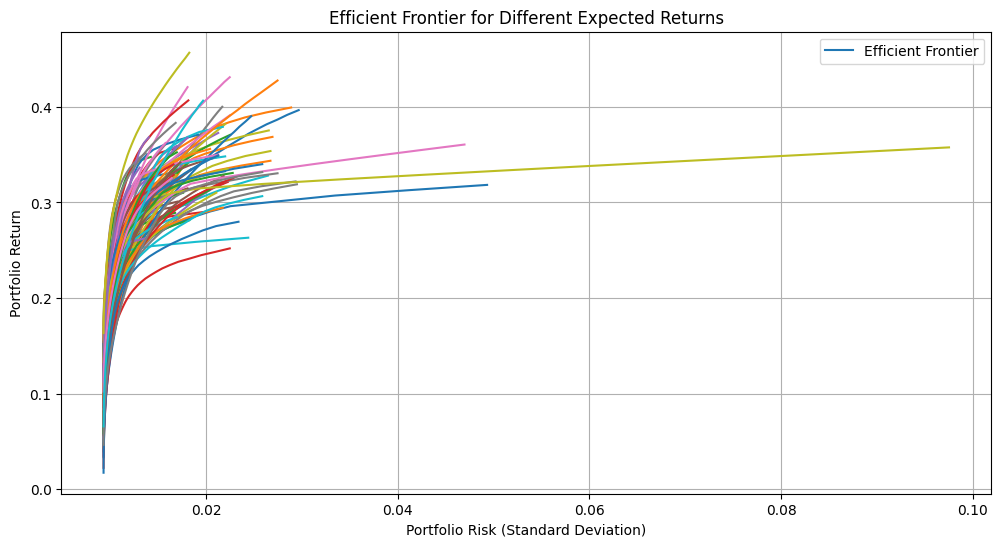

In [29]:
shrink_cov = LedoitWolf().fit(etf_returns).covariance_
frontier_results = plt_efficient_frontier(expected_returns, shrink_cov)

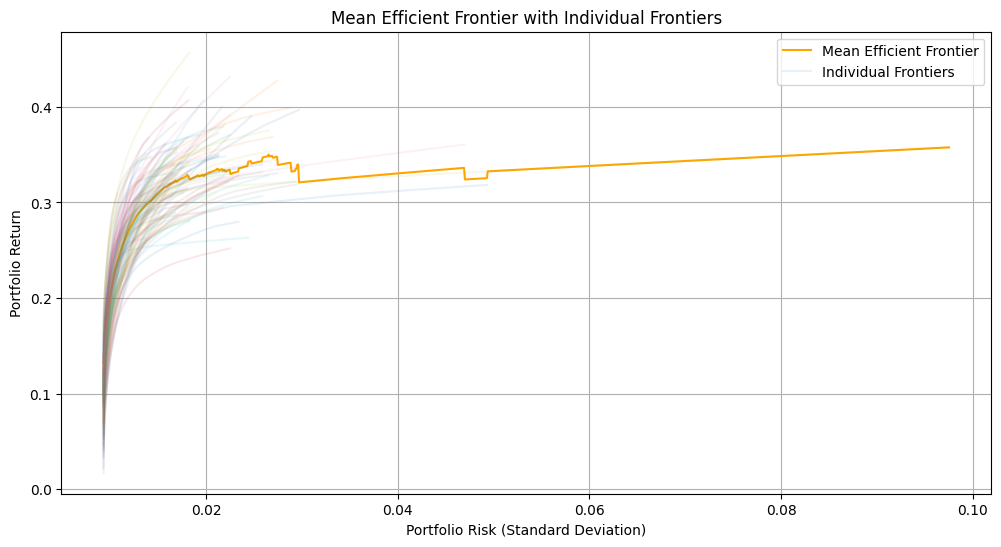

In [30]:
inter_polated_frontier_results, mean_frontier = plt_mean_efficient_frontier(frontier_results)

In [31]:
errors=inter_polated_frontier_results - mean_frontier
var_errors = np.nanvar(errors)
print(f"Variance of errors: {var_errors}")

Variance of errors: 0.0009532942574918547


Ledoit-Wolf의 noise 제거 효과는 약하지만 mean frontier에서 크게 벗어나지 않는 경향이 있어서 var_error가 낮게 나오는 경향이 있는것 같다.

5 Repeat Exercise 3, where this time you also detone the covariance matrix
before computing the one hundred efficient frontiers. Is the variance of the
errors significantly higher or lower? Why?

In [54]:
denoised_cov_matrix = get_denoised_cov_matrix(cov, q=etf_returns.shape[0]/etf_returns.shape[1], b_width=b_width)
denoised_corr_matrix = get_corr_matrix(denoised_cov_matrix)
denoted_corr_matrix = get_denoting_corr_matrix(denoised_corr_matrix=denoised_corr_matrix)
denoted_cov_matrix = denoted_corr_matrix * np.outer(np.sqrt(np.diag(cov)), np.sqrt(np.diag(cov)))

def preprocess_denoted_cov_and_mu(mu: np.ndarray, denoted_cov: np.ndarray):
    """
    detoned covariance와 mu를 PC space에서 최적화 가능한 형태로 변환
    """
    e_vals, e_vec = np.linalg.eigh(denoted_cov)
    tol = 1e-8
    idx = e_vals > tol

    # surviving eigenvectors and eigenvalues
    W_plus = e_vec[:, idx]
    Lambda_plus = np.diag(e_vals[idx])

    # mu projection
    mu_pc = W_plus.T @ mu

    return mu_pc, Lambda_plus, W_plus

frontier_results_all = []

for mu in expected_returns:
    # 1) PC space 변환
    mu_pc, cov_pc, W_plus = preprocess_denoted_cov_and_mu(mu, denoted_cov_matrix)
    
    # 2) 기존 efficient frontier 계산 (PC space에서)
    frontier_pc = construct_efficient_frontier(mu_pc, cov_pc)
    
    # 3) original space로 매핑
    frontier_orig = []
    for target_return, port_risk in frontier_pc:
        frontier_orig.append((target_return, port_risk))
    frontier_results_all.append(np.array(frontier_orig))


Optimization successful: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL, var=1.0000


/opt/homebrew/anaconda3/envs/AFML/lib/python3.12/site-packages/cvxpy/problems/problem.py:1510: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Error for target return -0.2765394830127519: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.
Error for target return -0.27074993890888793: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.
Error for target return 0.2323277557336343: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.
Error for target return -0.22492527185630196: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.
Error for target return -0.21966970348225393: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.
Error for target return -0.2144141351082059: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.
Error for target return -0.20915856673415786: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.
Error for target return -0.20390299836010983:

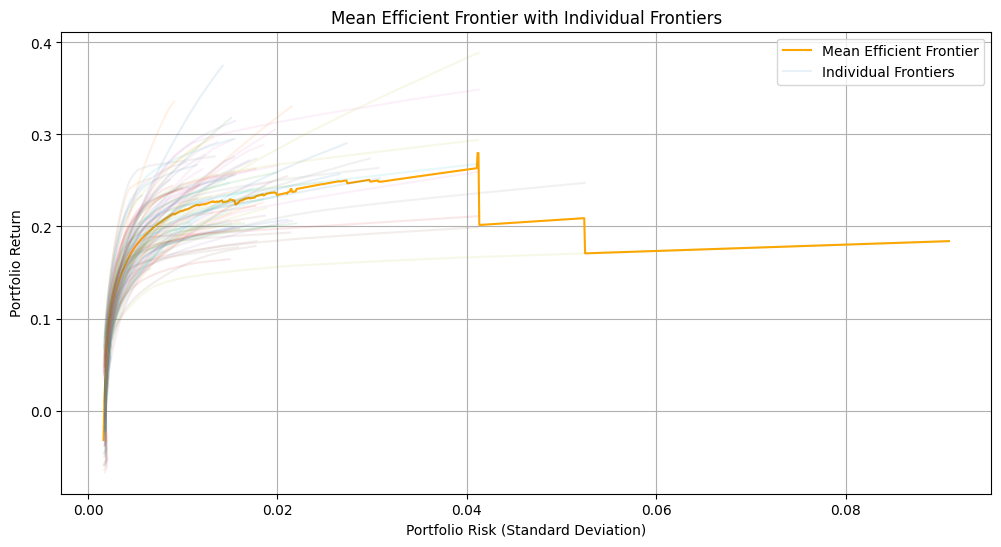

In [55]:
inter_polated_frontier_results, mean_frontier = plt_mean_efficient_frontier(frontier_results_all)

In [56]:
errors=inter_polated_frontier_results - mean_frontier
var_errors = np.nanvar(errors)
print(f"Variance of errors: {var_errors}")

Variance of errors: 0.0012406015372263162


Detoning은 시장 공통 요인(첫 번째 PC 등)을 제거하므로 raw mean frontier와 구조가 크게 달라질 수 있다. 따라서 실제로는 더 안정적일지는 몰라서 raw_mean_froniter와 구조가 크게 차이날 가능성이 있다.(signal까지 과도하게 제거가능)

6 What happens if you drop the components whose eigenvalues fall below a
given threshold? Can you still compute the efficient frontiers? How?

일정 이하의 eigen-value를 지우고 나면
이전의 방법처럼 singular하기 때문에 principal component space로 efficient frontier를 계산하면 efficient froniter를 계산할 수 있다.

7 Extend function fitKDE in Code Snippet 2.2, so that it estimates through
cross-validation the optimal value of bWidth.

Best bandwidth found: 4.977024 with score: -50.3694
Optimization successful: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL, var=1.0000
Estimated maximum eigenvalue: 3.7120, Number of ranks: 3


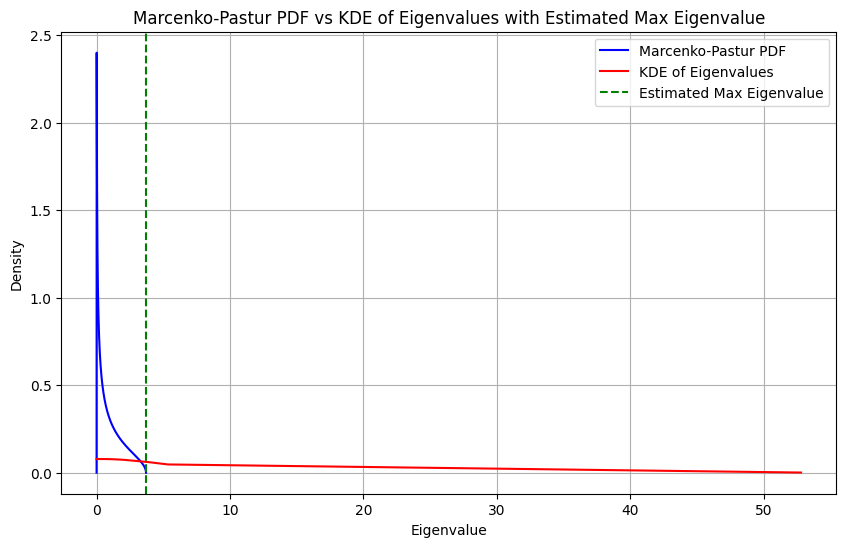

In [48]:
from sklearn.model_selection import KFold

def get_max_eval_auto_bwidth(e_val:np.ndarray, q:float, verbose=True, b_width_fold_cnt=5)-> Tuple[float, float]:
    '''
    Find the maximum eigenvalue and its corresponding bandwidth.
    '''
    def objective(var:np.ndarray, e_val, q, b_width, sample_size=1000):
        mp_pdf= get_marcenko_pastur_pdf(var[0], q, sample_size)
        kde_pdf = get_kde(e_val, b_width=b_width, x=mp_pdf.index.values)
        sse= np.sum((mp_pdf - kde_pdf) ** 2)
        return sse

    b_width_cand=np.linspace(-4, 1, 100)
    b_width_cand = 10 ** b_width_cand

    from sklearn.model_selection import KFold

    def score_bwidth_cv(e_val, b_width, n_splits=5):
        kf = KFold(n_splits=n_splits, shuffle=True)
        log_likelihoods = []
        for train_idx, val_idx in kf.split(e_val):
            train_e = e_val[train_idx]
            val_e = e_val[val_idx]
            kde = KernelDensity(kernel='gaussian', bandwidth=b_width).fit(train_e.reshape(-1,1))
            log_likelihoods.append(kde.score(val_e.reshape(-1,1)))
        return np.mean(log_likelihoods)

    best_b_width = None
    best_score = -np.inf
    for b_width in b_width_cand:
        score = score_bwidth_cv(e_val, b_width, n_splits=b_width_fold_cnt)
        if score > best_score:
            best_score = score
            best_b_width = b_width
    print(f"Best bandwidth found: {best_b_width:.6f} with score: {best_score:.4f}")

    out=minimize(lambda *x: objective(*x), 0.5, args=(e_val, q, best_b_width), bounds=[(1e-5, 1-1e-5),])
    var=out.x[0] if out.success else 1
    if out.success and verbose:
        print(f"Optimization successful: {out.message}, var={var:.4f}")
    e_max= var * (1 + (1/q)**0.5)**2
    return e_max, var, best_b_width

e_val, e_vec = get_eigen_values_and_vectors(corr)
e_max, var, b_width = get_max_eval_auto_bwidth(np.diag(e_val), q=etf_returns.shape[0]/etf_returns.shape[1])
eig_values = np.diag(e_val)
eig_values_sorted = np.sort(eig_values)[::-1]  # 내림차순
n_ranks = np.sum(eig_values_sorted > e_max)

pdf1= get_marcenko_pastur_pdf(var=var, q=etf_returns.shape[0]/etf_returns.shape[1], sample_size=1000)
pdf2 = get_kde(np.diag(e_val), b_width=b_width)
plt.figure(figsize=(10, 6))
plt.plot(pdf1.index, pdf1, label='Marcenko-Pastur PDF', color='blue')
plt.plot(pdf2.index, pdf2, label='KDE of Eigenvalues', color='red')
plt.axvline(e_max, color='green', linestyle='--', label='Estimated Max Eigenvalue')
plt.title('Marcenko-Pastur PDF vs KDE of Eigenvalues with Estimated Max Eigenvalue')
plt.xlabel('Eigenvalue')
plt.ylabel('Density')
plt.legend()
plt.grid()  

print(f"Estimated maximum eigenvalue: {e_max:.4f}, Number of ranks: {n_ranks}")